In [423]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max.columns', None)

### Entendendo os Datasets

In [349]:
df_orders = pd.read_csv('olist_orders_dataset.csv')
df_customers = pd.read_csv('olist_customers_dataset.csv') # dados do cliente
df_geolocation = pd.read_csv('olist_geolocation_dataset.csv')
df_items = pd.read_csv('olist_order_items_dataset.csv') # dados do produto que foi pedido
df_payments = pd.read_csv('olist_order_payments_dataset.csv') # dados do pagamento
df_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
df_products = pd.read_csv('olist_products_dataset.csv') # descrição de cada produto
df_sellers = pd.read_csv('olist_sellers_dataset.csv') # descrição de cada vendedor
df_translation= pd.read_csv('product_category_name_translation.csv')

In [350]:
df_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [351]:
lista_name = ['orders','customers','geolocation','items','payments','reviews','products','sellers','translation']
dfs = [df_orders, df_customers, df_geolocation, df_items, df_payments, df_reviews, df_products, df_sellers, df_translation]

dict_nomes = dict(zip(lista_name, dfs))

In [352]:
for name, df in dict_nomes.items():
    for column in df.columns:
        if df[column].isnull().sum() != 0:  # Verifica quais colunas de qual dataframe tem valores nulos
            print(f'{name} - {column}')

orders - order_approved_at
orders - order_delivered_carrier_date
orders - order_delivered_customer_date
reviews - review_comment_title
reviews - review_comment_message
products - product_category_name
products - product_name_lenght
products - product_description_lenght
products - product_photos_qty
products - product_weight_g
products - product_length_cm
products - product_height_cm
products - product_width_cm


Alguns parâmetros são possíveis deduzir a razão de apresentarem valores faltantes, como os que são relacionados à situação de entrega por exemplo ('order_delivered_carrier_date', 'order_delivered_customer_date'), são pedidos em que a compra não foi finalizada; ou os relacionados às avaliações ('review_comment_title', 'review_comment_title') também são deduzíveis, porém outros não são tão intuitivos, necessitando de uma melhor análise.

In [353]:
df_products.isnull().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [354]:
df_products[df_products.product_category_name.isnull()].product_name_lenght.unique()

array([nan])

O código acima mostra que todos os produtos sem categoria também não possuem nome e, consequentemente, não há tamanho de nome, descrição ou quantidade de fotos pois não podem ser reconhecidos.

#### Criando um dataset consolidado

In [355]:
df_items_products = df_items.merge(df_products, how='left', on='product_id')

In [356]:
df_items_products_sellers = df_items_products.merge(df_sellers, how='left', on='seller_id')

In [357]:
df_order_payments = df_orders.merge(df_payments, how='left', on='order_id')

In [358]:
df_order_payments_customers = df_order_payments.merge(df_customers, how='left', on='customer_id')

In [359]:
df_order_payments_customers.shape

(103887, 16)

In [360]:
df_consolidado = df_items_products_sellers.merge(df_order_payments_customers, how='outer', on='order_id')

In [361]:
df_consolidado.shape


(118434, 33)

In [362]:
# total de valores missing

df_consolidado.isnull().sum()

order_id                            0
order_item_id                     830
product_id                        830
seller_id                         830
shipping_limit_date               830
price                             830
freight_value                     830
product_category_name            2528
product_name_lenght              2528
product_description_lenght       2528
product_photos_qty               2528
product_weight_g                  850
product_length_cm                 850
product_height_cm                 850
product_width_cm                  850
seller_zip_code_prefix            830
seller_city                       830
seller_state                      830
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 176
order_delivered_carrier_date     2074
order_delivered_customer_date    3397
order_estimated_delivery_date       0
payment_sequential                  3
payment_type

Com a criação de um dataset consolidado apareceram parâmetros com valores faltantes que antes não apresentavam, como 'order_item_id' e 'payment_type' e que precisam ser investigados.

In [363]:
df_consolidado[df_consolidado.order_item_id.isnull()]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
117604,8e24261a7e58791d10cb1bf9da94df5c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaN,NaN,2017-12-05 00:00:00,1.0,credit_card,5.0,84.00,41fc647b8c6bd979b1b6364b60471b50,89288,sao bento do sul,SC
117605,c272bcd21c287498b4883c7512019702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaN,NaN,2018-02-16 00:00:00,1.0,credit_card,1.0,97.68,0e634b16e4c585acbd7b2e8276ce6677,11701,praia grande,SP
117606,37553832a3a89c9b2db59701c357ca67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaN,NaN,2017-09-05 00:00:00,1.0,boleto,1.0,132.46,596ed6d7a35890b3fbac54ec01f69685,2318,sao paulo,SP
117607,d57e15fb07fd180f06ab3926b39edcd2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,NaN,NaN,2018-02-06 00:00:00,1.0,boleto,1.0,134.38,2349bbb558908e0955e98d47dacb7adb,48607,paulo afonso,BA
117608,00b1cb0320190ca0daa2c88b35206009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaN,NaN,NaN,2018-09-12 00:00:00,1.0,not_defined,1.0,0.00,4fa4365000c7090fcb8cad5713c6d3db,1151,sao paulo,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118429,aaab15da689073f8f9aa978a390a69d1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01-17 03:37:34,NaN,NaN,2018-02-06 00:00:00,1.0,boleto,1.0,210.09,a33e0969408919ba06779f497ead93ec,7025,guarulhos,SP
118430,3a3cddda5a7c27851bd96c3313412840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaN,NaN,NaN,2018-10-01 00:00:00,1.0,voucher,1.0,63.89,e90598185d2427a35e32ef241a5c04aa,11075,santos,SP
118431,a89abace0dcc01eeb267a9660b5ac126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaN,NaN,NaN,2018-09-27 00:00:00,1.0,voucher,1.0,107.13,d05c44a138277ad325d915c6b7ccbcdf,5344,sao paulo,SP
118432,a69ba794cc7deb415c3e15a0a3877e69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaN,NaN,2017-09-15 00:00:00,1.0,credit_card,2.0,195.91,e72a90a2b29fe1a8795b284aaaa3246f,22723,rio de janeiro,RJ


In [364]:
df_consolidado[df_consolidado.order_status.isin(['unavailable', 'canceled'])].isnull().sum()

order_id                            0
order_item_id                     822
product_id                        822
seller_id                         822
shipping_limit_date               822
price                             822
freight_value                     822
product_category_name             837
product_name_lenght               837
product_description_lenght        837
product_photos_qty                837
product_weight_g                  822
product_length_cm                 822
product_height_cm                 822
product_width_cm                  822
seller_zip_code_prefix            822
seller_city                       822
seller_state                      822
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 156
order_delivered_carrier_date     1316
order_delivered_customer_date    1388
order_estimated_delivery_date       0
payment_sequential                  0
payment_type

DOs 830 valores faltantes em 'order_item_id', 'product_id', etc, 822 são devido a pedidos com 'order_status' igual a 'unavailable' ou 'canceled'.

In [365]:
# 8 pedidos que sobraram com order_item_id nulos
df_consolidado[(df_consolidado.order_item_id.isnull()) & (~df_consolidado.order_status.isin(['unavailable', 'canceled']))]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
117663,b5359909123fa03c50bdb0cfed07f098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,438449d4af8980d107bf04571413a8e7,created,2017-12-05 01:07:52,NaN,NaN,NaN,2018-01-11 00:00:00,1.0,credit_card,10.0,160.94,55fbb57fd54c35a38c80c2a032a6ca6e,15300,general salgado,SP
117681,dba5062fbda3af4fb6c33b1e040ca38f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,964a6df3d9bdf60fe3e7b8bb69ed893a,created,2018-02-09 17:21:04,NaN,NaN,NaN,2018-03-07 00:00:00,1.0,boleto,1.0,137.60,2e015e68fbfa36910263df5384e8e45c,73401,brasilia,DF
117775,7a4df5d8cff4090e541401a20a22bb80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,725e9c75605414b21fd8c8d5a1c2f1d6,created,2017-11-25 11:10:33,NaN,NaN,NaN,2017-12-12 00:00:00,1.0,boleto,1.0,37.84,355862aa14375fe3950ee04fef9c7a53,22621,rio de janeiro,RJ
117787,a68ce1686d536ca72bd2dadc4b8671e5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,d7bed5fac093a4136216072abaf599d5,shipped,2016-10-05 01:47:40,2016-10-07 03:11:22,2016-11-07 16:37:37,NaN,2016-12-01 00:00:00,1.0,boleto,1.0,77.73,f15a952dfc52308d0361288fbf42c7b3,91250,porto alegre,RS
118074,35de4050331c6c644cddc86f4f2d0d64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4ee64f4bfc542546f422da0aeb462853,created,2017-12-05 01:07:58,NaN,NaN,NaN,2018-01-08 00:00:00,1.0,credit_card,7.0,105.87,10d5890ed5e7ec78a7db23b5ac579b17,93025,sao leopoldo,RS
118093,2ce9683175cdab7d1c95bcbb3e36f478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b2d7ae0415dbbca535b5f7b38056dd1f,invoiced,2016-10-05 21:03:33,2016-10-06 07:46:39,NaN,NaN,2016-11-25 00:00:00,1.0,boleto,1.0,73.04,6a2da481aa7827b951175772a0fe8bb8,16012,aracatuba,SP
118098,90ab3e7d52544ec7bc3363c82689965f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7d61b9f4f216052ba664f22e9c504ef1,created,2017-11-06 13:12:34,NaN,NaN,NaN,2017-12-01 00:00:00,1.0,credit_card,6.0,245.85,161e5b2b4513edb336986a8909218365,87720,paranavai,PR
118187,e04f1da1f48bf2bbffcf57b9824f76e1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0d00d77134cae4c58695086ad8d85100,invoiced,2016-10-05 13:22:20,2016-10-06 15:51:38,NaN,NaN,2016-11-29 00:00:00,1.0,credit_card,7.0,76.19,8886115442775dd8a20c2dcc921c7cc8,88070,florianopolis,SC


In [366]:
# Pedidos com tipo de pagamento faltando (total de 3)
df_consolidado[df_consolidado.payment_type.isnull()]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
88091,bfbd0f9bdef84302105ad712db648a6c,1.0,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,beleza_saude,34.0,1036.0,1.0,1000.0,16.0,16.0,16.0,81810.0,curitiba,PR,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00,NaN,NaN,NaN,NaN,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP
88092,bfbd0f9bdef84302105ad712db648a6c,2.0,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,beleza_saude,34.0,1036.0,1.0,1000.0,16.0,16.0,16.0,81810.0,curitiba,PR,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00,NaN,NaN,NaN,NaN,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP
88093,bfbd0f9bdef84302105ad712db648a6c,3.0,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,beleza_saude,34.0,1036.0,1.0,1000.0,16.0,16.0,16.0,81810.0,curitiba,PR,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00,NaN,NaN,NaN,NaN,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP


Verifica-se que é um cliente que pediu três produtos iguais. Neste caso pode ser que tenha ocorrido algum erro na hora de apurar os dados de pagamento ou o cliente pode ter dado um golpe e não ter pago o produto.

Entendido a razão de valores faltantes, partiremos agora para analisar o dataset consolidado procurando responder a algumas perguntas de negócios.
- Qual categoria de produto que mais vende e seu faturamento?
- Qual categoria possuiu o maior faturamento?
- Qual estado possui mais clientes?
- Qual dia da semana que há mais vendas e a que horas?
- Qual tipo de pagamento que as pessoas mais utilizam?
- O valor do frete influencia na hora de finalizar a compra?


#### 1 - Qual categoria de produto que mais vende e seu faturamento?

Text(0, 0.5, 'Quantidade de venda')

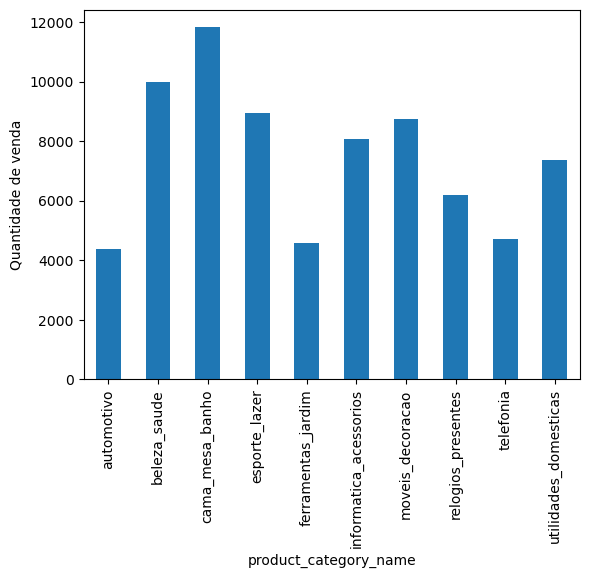

In [521]:
mais_vendas_top10 = df_consolidado.groupby('product_category_name').order_id.count().sort_values(ascending=False)[0:10]
mais_vendas_top10.sort_index().plot(kind='bar')
plt.ylabel('Quantidade de venda')

In [517]:
mais_vendas_top10.index

Index(['cama_mesa_banho', 'beleza_saude', 'esporte_lazer', 'moveis_decoracao',
       'informatica_acessorios', 'utilidades_domesticas', 'relogios_presentes',
       'telefonia', 'ferramentas_jardim', 'automotivo'],
      dtype='object', name='product_category_name')

Text(0, 0.5, 'Faturamento')

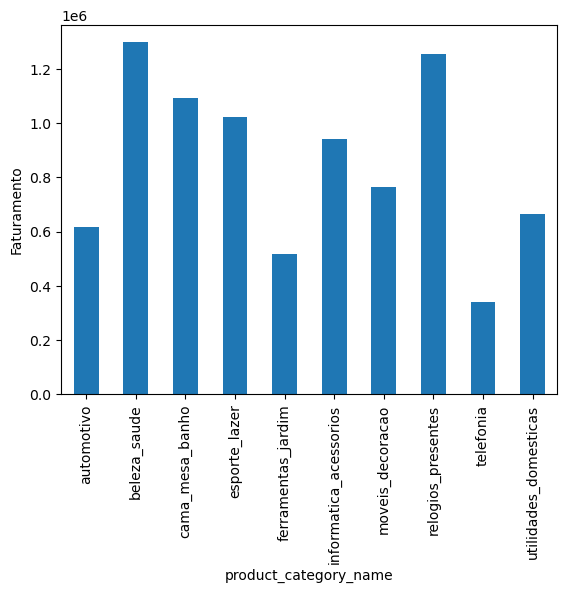

In [520]:
faturamento_top10_mais_vendas= df_consolidado[df_consolidado['product_category_name'].isin(mais_vendas_top10.index)].groupby('product_category_name').price.sum()
faturamento_top10_mais_vendas.plot(kind='bar')

plt.ylabel('Faturamento')


In [466]:
faturamento_top10_mais_vendas

product_category_name
automotivo                 616752.51
beleza_saude              1297490.77
cama_mesa_banho           1092551.02
esporte_lazer             1023996.34
ferramentas_jardim         518217.54
informatica_acessorios     942277.57
moveis_decoracao           765093.89
relogios_presentes        1253143.30
telefonia                  339399.16
utilidades_domesticas      666587.00
Name: price, dtype: float64

Podemos perceber que a categoria cama,mesa e banho foi a que possuiu mais produtos vendidos, com um faturamento de R$1.092.551,02.

#### 2 - Qual categoria possuiu o maior faturamento?


Text(0, 0.5, 'Faturamento')

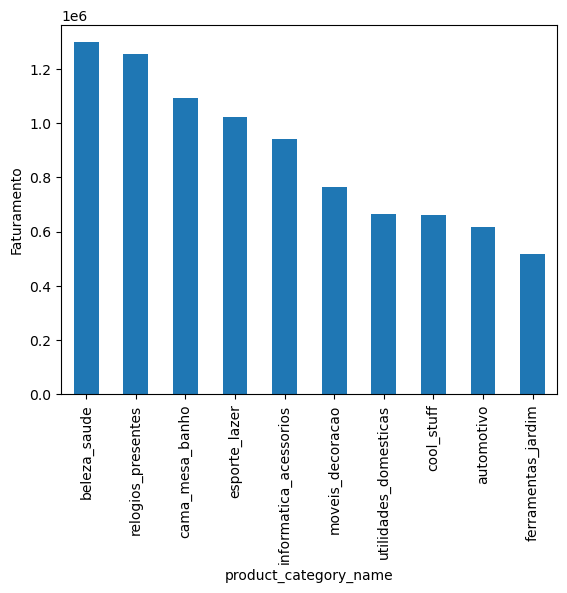

In [471]:
maior_faturamento_top10 = df_consolidado.groupby('product_category_name').price.sum().sort_values(ascending=False)[0:10]

plt.ylabel('Faturamento')

In [472]:
maior_faturamento_top10

product_category_name
beleza_saude              1297490.77
relogios_presentes        1253143.30
cama_mesa_banho           1092551.02
esporte_lazer             1023996.34
informatica_acessorios     942277.57
moveis_decoracao           765093.89
utilidades_domesticas      666587.00
cool_stuff                 662309.49
automotivo                 616752.51
ferramentas_jardim         518217.54
Name: price, dtype: float64

A categoria que possuiu o maior faturamento foi a de beleza e saúde com um faturamento de R$1.297.490,77.

#### 3 - Qual estado possui mais clientes?

In [473]:
df_consolidado.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277.0,volta redonda,SP,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,1.0,credit_card,2.0,72.19,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ
1,00018f77f2f0320c557190d7a144bdd3,1.0,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,3471.0,sao paulo,SP,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,1.0,credit_card,3.0,259.83,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP
2,000229ec398224ef6ca0657da4fc703e,1.0,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,37564.0,borda da mata,MG,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,1.0,credit_card,5.0,216.87,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG
3,00024acbcdf0a6daa1e931b038114c75,1.0,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,14403.0,franca,SP,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,1.0,credit_card,2.0,25.78,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1.0,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,87900.0,loanda,PR,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,1.0,credit_card,3.0,218.04,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP


<AxesSubplot: xlabel='customer_state'>

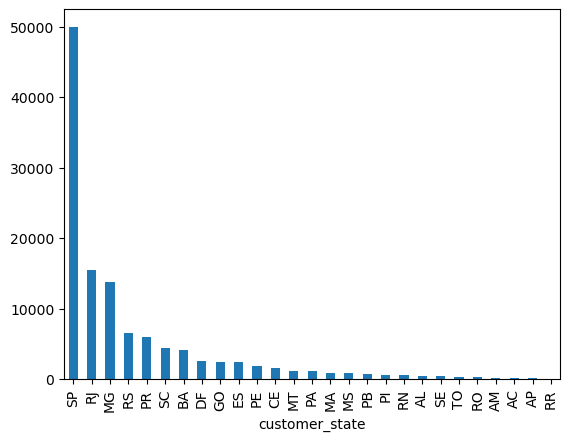

In [477]:
estados_com_mais_clientes = df_consolidado.groupby('customer_state').order_id.count().sort_values(ascending=False)
estados_com_mais_clientes.plot(kind='bar')

In [480]:
estados_com_mais_clientes[0:5]

customer_state
SP    49967
RJ    15420
MG    13738
RS     6521
PR     6017
Name: order_id, dtype: int64

O estado com mais clientes é o estado de SP. Com essa informação é possível traçar estratégias em relação a captação de clientes.

#### 4 - Qual dia da semana que há mais vendas e a que horas?


In [484]:
df_consolidado.order_status.value_counts()

delivered      115038
shipped          1245
canceled          745
unavailable       650
processing        375
invoiced          373
created             5
approved            3
Name: order_status, dtype: int64

Vamos considerar como venda todos os pedidos exceto com order_status igual a 'canceled' e 'unavailable'.

In [490]:
df_vendidos = df_consolidado[~df_consolidado['order_status'].isin(['canceled','unavailable'])]
df_vendidos.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277.0,volta redonda,SP,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,1.0,credit_card,2.0,72.19,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ
1,00018f77f2f0320c557190d7a144bdd3,1.0,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,3471.0,sao paulo,SP,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,1.0,credit_card,3.0,259.83,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP
2,000229ec398224ef6ca0657da4fc703e,1.0,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,37564.0,borda da mata,MG,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,1.0,credit_card,5.0,216.87,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG
3,00024acbcdf0a6daa1e931b038114c75,1.0,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,14403.0,franca,SP,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,1.0,credit_card,2.0,25.78,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1.0,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,87900.0,loanda,PR,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,1.0,credit_card,3.0,218.04,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP


In [491]:
# Iremos usar como parâmetro a coluna order_purchase_timestamp
df_vendidos.order_purchase_timestamp.info()

<class 'pandas.core.series.Series'>
Int64Index: 117039 entries, 0 to 118187
Series name: order_purchase_timestamp
Non-Null Count   Dtype 
--------------   ----- 
117039 non-null  object
dtypes: object(1)
memory usage: 1.8+ MB


In [496]:
df_vendidos['order_purchase_timestamp'] = pd.to_datetime(df_vendidos['order_purchase_timestamp'], errors='coerce')

df_vendidos.order_purchase_timestamp.isnull().sum()

C:\Users\danil\AppData\Local\Temp\ipykernel_4824\523313933.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vendidos['order_purchase_timestamp'] = pd.to_datetime(df_vendidos['order_purchase_timestamp'], errors='coerce')


0

In [497]:
df_vendidos['day_of_the_week'] = df_vendidos['order_purchase_timestamp'].apply(lambda x: x.strftime('%A'))

C:\Users\danil\AppData\Local\Temp\ipykernel_4824\44516737.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vendidos['day_of_the_week'] = df_vendidos['order_purchase_timestamp'].apply(lambda x: x.strftime('%A'))


<AxesSubplot: xlabel='day_of_the_week', ylabel='count'>

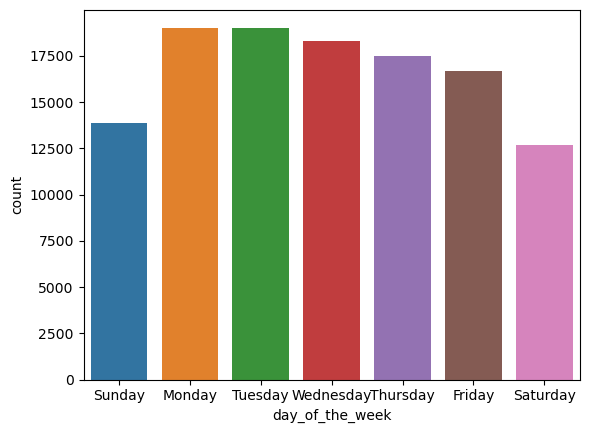

In [514]:
day_order = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

df_vendidos['day_of_the_week'].value_counts()

sns.countplot(data = df_vendidos, x='day_of_the_week', order=day_order)



In [522]:
df_vendidos['day_of_the_week'].value_counts()


Monday       19025
Tuesday      18987
Wednesday    18294
Thursday     17504
Friday       16696
Sunday       13868
Saturday     12665
Name: day_of_the_week, dtype: int64

O dia da semana que houve mais vendas foi na Segunda-feira.

C:\Users\danil\AppData\Local\Temp\ipykernel_4824\609945962.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vendidos['hour_day'] = df_vendidos['order_purchase_timestamp'].apply(lambda x: x.strftime('%H'))


Text(0.5, 0, 'Hour')

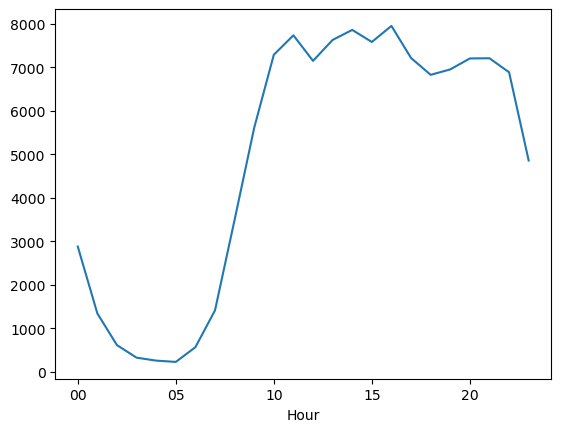

In [529]:
df_vendidos['hour_day'] = df_vendidos['order_purchase_timestamp'].apply(lambda x: x.strftime('%H'))
df_vendidos['hour_day'].value_counts().sort_index().plot()
plt.xlabel('Hour')

In [532]:
df_vendidos['hour_day'].value_counts().sort_values(ascending=False)[0:3]

16    7952
14    7860
11    7736
Name: hour_day, dtype: int64

O horário com mais vendas foi às 16 horas.

#### 5 - Qual tipo de pagamento que as pessoas mais utilizam?


#### 6 - O valor do frete influencia na hora de finalizar a compra?